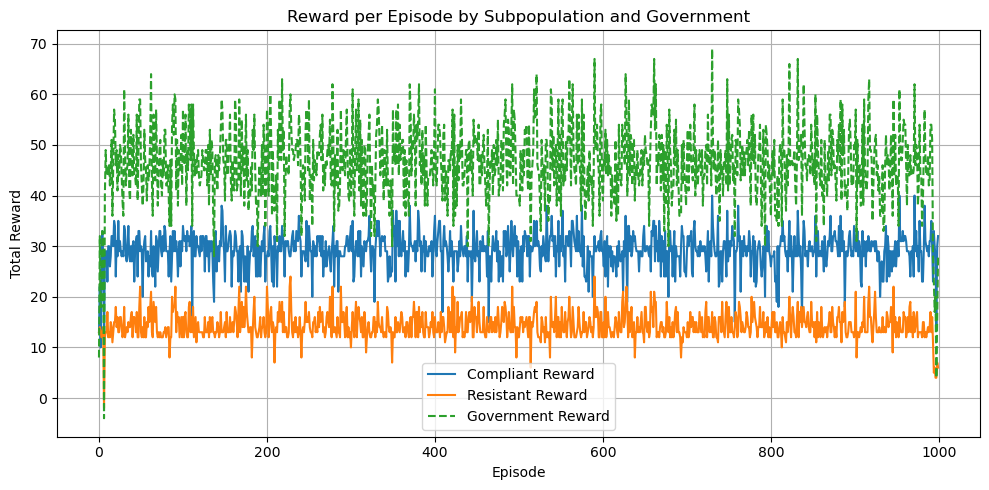


Sample transitions for Compliant population:


,Episode,Step,State,Action,Reward,Next State
0,0,0,High,DoNothing,-3,Low
1,0,1,Low,Mitigate,7,Low
2,0,2,Low,Mitigate,7,Low
3,0,3,Low,DoNothing,2,Low
4,1,0,High,Mitigate,10,Medium
5,1,1,Medium,DoNothing,1,Medium
6,1,2,Medium,DoNothing,1,High
7,1,3,High,Mitigate,10,High
8,2,0,Medium,DoNothing,1,Low
9,2,1,Low,Mitigate,7,Medium



Sample transitions for Resistant population:


,Episode,Step,State,Action,Reward,Next State
0,0,0,Low,DoNothing,3,Low
1,0,1,Low,DoNothing,3,Medium
2,0,2,Medium,Mitigate,4,Low
3,0,3,Low,DoNothing,3,Medium
4,1,0,Low,DoNothing,3,Medium
5,1,1,Medium,Mitigate,4,Medium
6,1,2,Medium,Mitigate,4,Low
7,1,3,Low,DoNothing,3,Medium
8,2,0,Low,DoNothing,3,Medium
9,2,1,Medium,DoNothing,2,Medium



Learned Policies from DRQN for Each Subpopulation:

Compliant Policy:
  State 'Low': Mitigate (Q = 77.17)
  State 'Medium': Mitigate (Q = 77.15)
  State 'High': Mitigate (Q = 77.14)

Resistant Policy:
  State 'Low': DoNothing (Q = 37.28)
  State 'Medium': DoNothing (Q = 37.26)
  State 'High': DoNothing (Q = 37.18)


In [2]:
# Deep Recurrent Q-Network (DRQN) for Infectious Disease Game (Keras + TensorFlow + Visualization + Multiple Agents)

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

# Define states and actions
states = ['Low', 'Medium', 'High']
actions = ['Mitigate', 'DoNothing']
state_to_index = {state: i for i, state in enumerate(states)}
action_to_index = {action: i for i, action in enumerate(actions)}

# Subpopulations
population_types = ['Compliant', 'Resistant']
population_preferences = {
    'Compliant': {'Mitigate': 2, 'DoNothing': 0},
    'Resistant': {'Mitigate': -2, 'DoNothing': 1}
}

# Government public health rewards
government_reward_table = {
    ('Low', 'Mitigate'): 5,
    ('Low', 'DoNothing'): -1,
    ('Medium', 'Mitigate'): 7,
    ('Medium', 'DoNothing'): 0,
    ('High', 'Mitigate'): 10,
    ('High', 'DoNothing'): -5,
}

government_reward_history = []

# Parameters
alpha = 0.01
gamma = 0.9
epsilon = 0.1
episodes = 1000
sequence_length = 4
hidden_size = 32

# Reward function
reward_table = {
    ('Low', 'Mitigate'): 5,
    ('Low', 'DoNothing'): 2,
    ('Medium', 'Mitigate'): 6,
    ('Medium', 'DoNothing'): 1,
    ('High', 'Mitigate'): 8,
    ('High', 'DoNothing'): -3,
}

# Transition probabilities
transition_table = {
    ('Low', 'Mitigate'): [0.8, 0.2, 0.0],
    ('Low', 'DoNothing'): [0.6, 0.4, 0.0],
    ('Medium', 'Mitigate'): [0.6, 0.3, 0.1],
    ('Medium', 'DoNothing'): [0.3, 0.4, 0.3],
    ('High', 'Mitigate'): [0.5, 0.3, 0.2],
    ('High', 'DoNothing'): [0.2, 0.3, 0.5],
}

# Prepare input as one-hot vectors
def one_hot(state):
    vec = np.zeros(len(states))
    vec[state_to_index[state]] = 1
    return vec

# Build DRQN model using Keras
def create_model():
    model = models.Sequential([
        layers.Input(shape=(sequence_length, len(states))),
        layers.LSTM(hidden_size),
        layers.Dense(len(actions))
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=alpha), loss='mse')
    return model

# Initialize models and trackers
models_by_population = {ptype: create_model() for ptype in population_types}
buffers_by_population = {ptype: deque(maxlen=1000) for ptype in population_types}
reward_history_by_population = {ptype: [] for ptype in population_types}
step_log = {ptype: [] for ptype in population_types}

# Training loop
for episode in range(episodes):
    total_gov_reward = 0
    for population in population_types:
        model = models_by_population[population]
        buffer = buffers_by_population[population]
        episode_reward = 0
        state = random.choice(states)

        for t in range(sequence_length):
            state_vec = one_hot(state)

            if random.random() < epsilon:
                action = random.choice(actions)
            else:
                input_tensor = np.array([[state_vec] * sequence_length])
                q_values = model.predict(input_tensor, verbose=0)[0]
                action = actions[np.argmax(q_values)]

            base_reward = reward_table[(state, action)]
            preference_reward = population_preferences[population][action]
            reward = base_reward + preference_reward
            gov_reward = government_reward_table[(state, action)]
            total_gov_reward += gov_reward

            probs = transition_table[(state, action)]
            next_state = random.choices(states, probs)[0]
            next_state_vec = one_hot(next_state)

            buffer.append((state_vec, action_to_index[action], reward, next_state_vec))
            episode_reward += reward

            step_log[population].append({
                'Episode': episode,
                'Step': t,
                'State': state,
                'Action': action,
                'Reward': reward,
                'Next State': next_state
            })

            state = next_state

        reward_history_by_population[population].append(episode_reward)

        if len(buffer) >= sequence_length:
            sample = list(random.sample(buffer, sequence_length))
            seq_states = np.array([[s[0] for s in sample]])
            seq_actions = [s[1] for s in sample]
            seq_rewards = [s[2] for s in sample]
            seq_next_states = np.array([[s[3] for s in sample]])

            target_q = model.predict(seq_states, verbose=0)[0]
            next_q = model.predict(seq_next_states, verbose=0)[0]

            for i in range(sequence_length):
                target_q[seq_actions[i]] = seq_rewards[i] + gamma * np.max(next_q)

            model.fit(seq_states, np.array([target_q]), verbose=0)

    government_reward_history.append(total_gov_reward)

# Plot learning curves
plt.figure(figsize=(10, 5))
for ptype in population_types:
    plt.plot(reward_history_by_population[ptype], label=f'{ptype} Reward')
plt.plot(government_reward_history, label='Government Reward', linestyle='--')
plt.title('Reward per Episode by Subpopulation and Government')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step-by-step state-action transitions
for ptype in population_types:
    df = pd.DataFrame(step_log[ptype])
    print(f"\nSample transitions for {ptype} population:")
    display(df.head(10))

# Print learned policies
print("\nLearned Policies from DRQN for Each Subpopulation:")
for population in population_types:
    print(f"\n{population} Policy:")
    model = models_by_population[population]
    for state in states:
        state_vec = np.array([[one_hot(state)] * sequence_length])
        q_values = model.predict(state_vec, verbose=0)[0]
        best_action = actions[np.argmax(q_values)]
        print(f"  State '{state}': {best_action} (Q = {q_values[np.argmax(q_values)]:.2f})")
